One bottleneck deep neural networks have been hypothesized to suffer from is the internal covariate
shift issue, where a layer’s input distribution changes as previous layers are updated, which
significantly slows the training.1 One promising direction to solve this problem is normalization.
Ioffe and Szegedy introduce batch normalization (BatchNorm) to stabilize activations based on
mean and variance statistics estimated from each training mini-batch. Unfortunately, the reliance
across training cases deprives BatchNorm of the capability in handling variable-length sequences,
though several researchers develop different strategies to enable it in RNNs [16, 8]. Instead, Salimans
and Kingma, propose weight normalization (WeightNorm) to reparameterize weight matrix
so as to decouple the length of weight vectors from their directions. Ba et al. [3] propose layer
normalization which differs from BatchNorm in that statistics are directly estimated from the same
layer without accessing other training cases. Due to its simplicity and effectiveness, LayerNorm has
been successfully applied to various deep neural models, and achieves state-of-the-art performance
on different tasks.

## RMSNorm

[paper](https://arxiv.org/pdf/1910.07467.pdf)

Paper claims that LayerNorm success is benifial from the re-scale invariance property rather than re-centrice invariance. And also the computation overhead created by layer norm is negligable in smaller model which pay major debts in deeper model structure.

Based on the issues and hypothesis claim they have introduced an RMSNorm and paritical RMSNorm (pRMSNorm) which retains the re-scale invariance property and show the comparable performance against LayerNorm but reduces the running time by 7%∼64% on different models.

## Our Work

In this work we are going to compare the gain for using differnt norm and analyse layer wise performance and report what changes helps the model wisely.

We are going to consider translationa as an base task to which we going to analyse our hypothesis.



#### Resource:
- [neural network as polytope](https://www.lesswrong.com/posts/eDicGjD9yte6FLSie/interpreting-neural-networks-through-the-polytope-lens#B__Scaling_activation_vectors_and_plotting_polytope_density)
- [re-examine-layernorm](https://www.lesswrong.com/posts/jfG6vdJZCwTQmG7kb/re-examining-layernorm)

## Load Dataset

In [1]:
from datasets import load_dataset


dataset = load_dataset("stas/wmt14-en-de-pre-processed")

Found cached dataset wmt14-en-de-pre-processed (/root/.cache/huggingface/datasets/stas___wmt14-en-de-pre-processed/ende/1.1.0/0385046ae875201d688e463d0e68e0d37aa1539cabd6be0841f9059319ec4aa7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 4548885
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2169
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2999
    })
})

## Model Declaration

In [3]:
import warnings

import torch.nn as nn
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

1.10.0+cu111


In [4]:
from torch.utils.tensorboard import SummaryWriter

log_dir = "Experimentation/no_norm"
writer = SummaryWriter(log_dir)

In [5]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

In [6]:
embedding = Embedding(2048, 512)

embedding_output = embedding(torch.as_tensor([[1, 2]]))

assert embedding_output.size()[-1] == 512
assert embedding_output.size()[-2] == 2

In [7]:
class SinSoidalPositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(SinSoidalPositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim
        

        pe = torch.zeros(max_seq_len, embed_model_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_model_dim, 2).float() * -(torch.log(torch.scalar_tensor(10000.0)) / embed_model_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """
      
        # make embeddings relatively larger
        x = x * torch.sqrt(torch.scalar_tensor(self.embed_dim))
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

In [8]:
pos_encoding = SinSoidalPositionalEmbedding(2048, 512)

pos_encoding = pos_encoding.pe[0, :, :]

In [9]:
print(pos_encoding.shape)

plt.pcolormesh(torch.concat([pos_encoding[:, 1::2], pos_encoding[:, ::2]], axis = -1).numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

torch.Size([2048, 512])


(0.0, 1.0)

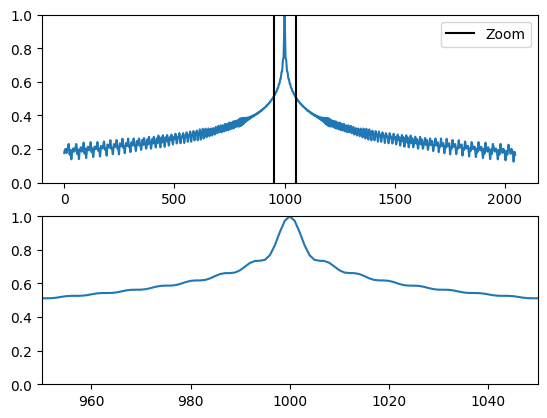

In [10]:
pos_encoding/=torch.norm(pos_encoding, dim=1, keepdim=True)
p = pos_encoding[1000]
dots = torch.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [11]:
embed_pt = SinSoidalPositionalEmbedding(max_seq_len=2048, embed_model_dim=512)
embed_en = SinSoidalPositionalEmbedding(max_seq_len=2048, embed_model_dim=512)


pt_emb = embed_pt(embedding_output)
en_emb = embed_en(embedding_output)

In [12]:
assert torch.all(pt_emb == en_emb)

In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    
        
    
        
    
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim 
        self.n_heads = n_heads
        
        assert embed_dim % 8 == 0, "Embedding dimention should be divisible of number of heads"
        self.single_head_dim = self.embed_dim // self.n_heads
       

        self.query_matrix = nn.Linear(self.embed_dim , self.embed_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.embed_dim  , self.embed_dim, bias=False)
        self.value_matrix = nn.Linear(self.embed_dim ,self.embed_dim , bias=False)
        
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim) 
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.n_heads, self.single_head_dim).transpose(1, 2)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.scalar_tensor(self.single_head_dim))
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
            
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
    
    def combine_heads(self, x):
        batch_size, _, seq_length, single_head_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)

    def forward(self,query,key,value,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512
        
        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder
        
        Returns:
           output vector from multihead attention
        """
        batch_size = key.size(0)
        seq_length = key.size(1)
        seq_length_query = query.size(1)
        
#         key = split_heads(key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
#         query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim)
#         value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim)
       
        k = self.key_matrix(key)
        q = self.query_matrix(query)   
        v = self.value_matrix(value)
        
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

       
        # computes attention
        scores = self.scaled_dot_product_attention(q, k, v, mask)
        
        #concatenated output
        concat = self.combine_heads(scores)
        
        output = self.out(concat) #(32,10,512) -> (32,10,512)
        return output

In [25]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out


class EncodeLayer(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8, add_norm=True):
        super(EncodeLayer, self).__init__()
        
        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        
        self.add_norm = add_norm
        if add_norm:
            self.norm1 = nn.LayerNorm(embed_dim) 
            self.norm2 = nn.LayerNorm(embed_dim)
        
        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim),
                          SwiGLU(expansion_factor*embed_dim),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self,query,key,value, attention_maks=None):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           norm2_out: output of transformer block
        
        """
        attention_out = self.attention(query,key,value, attention_maks)  #32x10x512
        attention_residual_out = attention_out + value  #32x10x512
        if self.add_norm:
            attention_residual_out = self.norm1(attention_residual_out)
        norm1_out = self.dropout1(attention_residual_out) #32x10x512

        feed_fwd_out = self.feed_forward(norm1_out) #32x10x512 -> #32x10x2048 -> 32x10x512
        feed_fwd_residual_out = feed_fwd_out + norm1_out #32x10x512
        if self.add_norm:
            feed_fwd_residual_out = self.norm2(feed_fwd_residual_out)
        norm2_out = self.dropout2(feed_fwd_residual_out) #32x10x512
        
        return norm2_out

In [26]:
class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention
        
    Returns:
        out: output of the encoder
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8, add_norm=True):
        super(TransformerEncoder, self).__init__()
        
        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = SinSoidalPositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList([EncodeLayer(embed_dim, expansion_factor, n_heads, add_norm) for i in range(num_layers)])
    
    def forward(self, x, attention_maks=None):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out, attention_maks)

        return out  #32x10x512

In [27]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8, add_norm=True):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.cross_attention = MultiHeadAttention(embed_dim, n_heads=8)
        
        self.add_norm = add_norm
        if self.add_norm:
            self.norm = nn.LayerNorm(embed_dim)
            self.norm1 = nn.LayerNorm(embed_dim) 
            self.norm2 = nn.LayerNorm(embed_dim)
            
        self.dropout = nn.Dropout(0.2)
        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim),
                          SwiGLU(expansion_factor*embed_dim),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
    
    def forward(self, query, key, value, mask, src_attention):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           mask: mask to be given for multi head attention 
        Returns:
           out: output of transformer block
    
        """
        
        #we need to pass mask mask only to fst attention
        attention = self.attention(query,query,query,mask=mask) #32x10x512
        query = attention + query
        if self.add_norm:
            query = self.norm(query)
        query = self.dropout(query)
        

        attention_out = self.cross_attention(query,key,value, src_attention)  #32x10x512
        attention_residual_out = attention_out + query  #32x10x512
        if self.add_norm:
            attention_residual_out = self.norm1(attention_residual_out)
        norm1_out = self.dropout1(attention_residual_out) #32x10x512

        feed_fwd_out = self.feed_forward(norm1_out) #32x10x512 -> #32x10x2048 -> 32x10x512
        feed_fwd_residual_out = feed_fwd_out + norm1_out #32x10x512
        
        if self.add_norm:
            feed_fwd_residual_out = self.norm2(feed_fwd_residual_out)
        out = self.dropout2(feed_fwd_residual_out) #32x10x512
        
        return out


class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8, add_norm=True):
        super(TransformerDecoder, self).__init__()
        """  
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = SinSoidalPositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8, add_norm=add_norm) 
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask, src_attention):
        
        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """
            
        
        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, mask, src_attention) 

        out = self.fc_out(x)

        return out

In [28]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length,num_layers=2, expansion_factor=4, n_heads=8, add_norm=True):
        super(Transformer, self).__init__()
        
        """  
        Args:
           embed_dim:  dimension of embedding 
           src_vocab_size: vocabulary size of source
           target_vocab_size: vocabulary size of target
           seq_length : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        
        self.target_vocab_size = target_vocab_size

        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads, add_norm=add_norm)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads, add_norm=add_norm)
        
    
    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask    

    def decode(self,src,trg):
        """
        for inference
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]
     
            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)
          
        
        return out_labels
    
    def forward(self, input_ids, attention_mask, decoder_ids):
        """
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out: final vector which returns probabilities of each target word
        """
        trg_mask = self.make_trg_mask(decoder_ids)
        enc_out = self.encoder(input_ids, attention_mask)
   
        logits = self.decoder(decoder_ids, enc_out, trg_mask, attention_mask)
        return logits

In [29]:
src_vocab_size = 11
target_vocab_size = 11
num_layers = 2
positional_embedding_seq_length= 12
add_norm = False


# let 0 be sos token and 1 be eos token
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, seq_length=positional_embedding_seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8, add_norm = add_norm)
model

Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(
      (embed): Embedding(11, 512)
    )
    (positional_encoder): SinSoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): EncodeLayer(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=512, out_features=512, bias=False)
          (key_matrix): Linear(in_features=512, out_features=512, bias=False)
          (value_matrix): Linear(in_features=512, out_features=512, bias=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): SwiGLU(
            (linear_gate): Linear(in_features=2048, out_features=2048, bias=True)
            (linear): Linear(in_features=2048, out_features=2048, bias=True)
          )
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, i

In [30]:
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1]])
attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])
trg = torch.tensor([[0, 1]])
print(src.shape,trg.shape)
out = model(src, attention_mask, trg)
out.shape

torch.Size([1, 12]) torch.Size([1, 2])


torch.Size([1, 2, 11])

## DataSet preperation

In [93]:
row = dataset["train"][9]
row

{'translation': {'de': 'Zu den Attentatsopfern, die es in jüngster Zeit in Sri Lanka zu beklagen gab, zählt auch Herr Kumar Ponnambalam, der dem Europäischen Parlament erst vor wenigen Monaten einen Besuch abgestattet hatte.',
  'en': 'One of the people assassinated very recently in Sri Lanka was Mr Kumar Ponnambalam, who had visited the European Parliament just a few months ago.'}}

In [94]:
tokenizer.batch_decode([tokenizer(row["translation"]["en"])["input_ids"]])

NameError: name 'tokenizer' is not defined

In [59]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/wmt19-de-en")

In [75]:
max_length = 128


def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["de"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs


tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,
    num_proc =10
)

Map (num_proc=10):   0%|          | 0/4548885 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/2169 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/2999 [00:00<?, ? examples/s]

In [78]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

In [79]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [81]:
tokenized_datasets["train"][0]

{'input_ids': [2642, 4584, 636, 9, 6, 9485, 2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'labels': [3257, 5763, 13, 6085, 5076, 1497, 6877, 2]}

## Training Loop Declaration

In [43]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.98, 0.99))

In [ ]:
def traing_step(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [37]:
import wandb

wandb.init(project='pytorchw_b')
wandb.watch(model, log='all')

# out = model(src, target)